/home/necphy/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/necphy/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/necphy/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


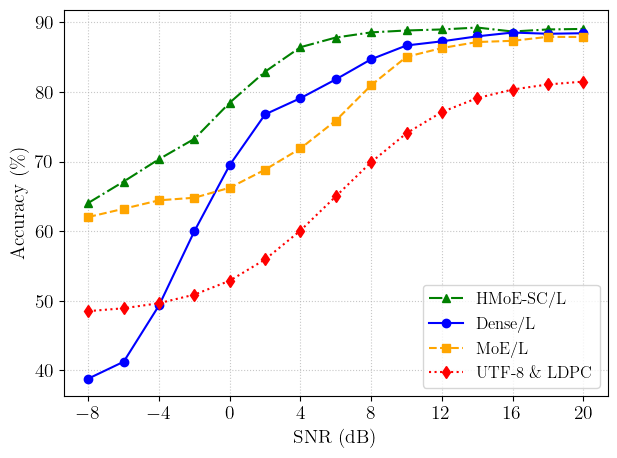

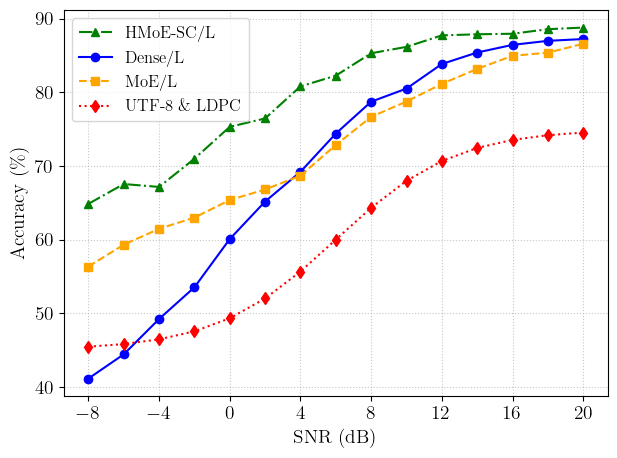

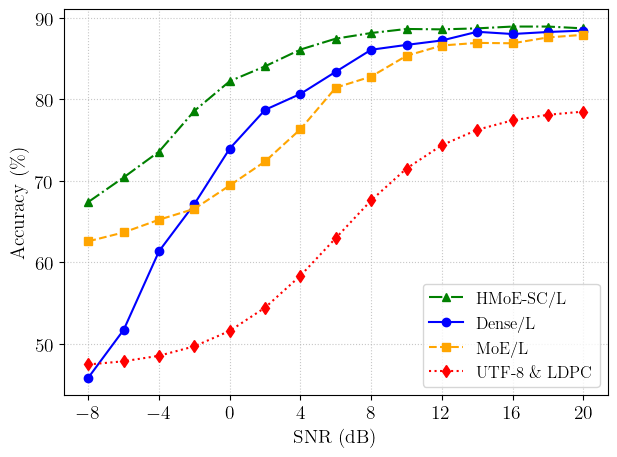

In [ ]:
# fig1: acc vs snr, lines: models

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random

import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom 
from conventional_model import Conventional_Com

from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset

import matplotlib.pyplot as plt

plt_paras = {'ytick.color' : 'black',
          'xtick.color' : 'black',
          'axes.labelcolor' : 'black',
          'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 13,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)


# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(1997) # 2006
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_dense = Transformer_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_encd_layer=6, transmit_dim=128, num_heads=8).to(device)

model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

model_moe = MoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

model_conv = Conventional_Com(emded_dim=512).to(device) 


# model_moe.load_state_dict(torch.load("checkpoints/Dense_snr12_20250604_055257.pt"))

model_dense.load_state_dict(torch.load("checkpoints_new/Dense_sizeL_6_1_8_632_20250701_011126.pt", weights_only=True))
model_hetereo.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_6_12_8_632_20250702_084802.pt", weights_only=True)) 
model_moe.load_state_dict(torch.load("checkpoints_new/MoE_sizeL_20250709_015013.pt", weights_only=True)) 
model_conv.load_state_dict(torch.load("checkpoints_new/Conv_Bert_20250708_224213.pt", weights_only=True))

# model_moe.eval()
model_dense.eval()
model_hetereo.eval()
model_moe.eval()
model_conv.eval()

# Load data
dataset = load_dataset("glue", "qqp")
batch_size = 256


# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

full_test_dataset = dataset["validation"]
subset_indices = random.sample(range(len(full_test_dataset)), len(full_test_dataset) // 10)
small_test_dataset = full_test_dataset.select(subset_indices)
test_dataset = QQPPromptDataset(small_test_dataset)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
)


snr_range = np.arange(-8, 22, 2)
fading_range = ['none', 'rayleigh', 'rician']

# Results dicts
results = {
    'dense': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'moe': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoe': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'conv': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
}


# Main evaluation loop
for snr in snr_range:
    for fading in fading_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:
            for arch_name, model in [('dense', model_dense), ('hmoe', model_hetereo), ('moe', model_moe),]:
                                    #  ('conv', model_conv)]: 

                for task in [0]:
                    with torch.no_grad():
                        if arch_name == 'dense':
                            outputs, input_ids, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=True)
                        elif arch_name == 'conv':
                            outputs = model(texts, float(snr), fading, rician_k=4.0, modal=True)
                        elif arch_name == 'moe':
                            outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=True)
                        else:
                            outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=False)

                        if task == 0:  # Classification
                            preds = outputs.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs.argmax(dim=-1).cpu().tolist()

                            tgt_ids_batch = input_ids[:, :len(pred_ids_batch[0])].cpu().tolist() 

                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=False)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=False)

                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total'] if metrics[arch_name]['total'] > 0 else 0
            bleu = np.mean(metrics[arch_name]['bleu_scores'])

            results[arch_name]['accuracy'][fading].append(acc*100)  
            results[arch_name]['bleu'][fading].append(bleu)

# results['conv']['accuracy']['none'] = [
#     48.52, 48.93, 49.66, 50.89, 52.89, 55.94, 60.09,
#     65.00, 69.91, 74.06, 77.11, 79.11, 80.34, 81.07, 81.48
# ]
# results['conv']['accuracy']['rayleigh'] = [
#     45.46, 45.82, 46.46, 47.55, 49.32, 52.01, 55.67,
#     60.00, 64.33, 67.99, 70.68, 72.45, 73.54, 74.18, 74.54
# ]

# results['conv']['accuracy']['rician'] = [
#     47.49, 47.88, 48.56, 49.72, 51.61, 54.47, 58.38,
#     63.00, 67.62, 71.53, 74.39, 76.28, 77.44, 78.12, 78.51
# ]


# Plotting: 3 figures, one per fading
# model_types = ['dense', 'moe', 'hetereoMoE']  # NEW
model_types = ['hmoe', 'dense', 'moe', 'conv']  
model_configs = {
    'dense': {'label': 'Dense/L', 'color': 'blue', 'marker': 'o', 'linestyle': '-'},
    'moe': {'label': 'MoE/L', 'color': 'orange', 'marker': 's', 'linestyle': '--'},
    'hmoe': {'label': 'HMoE-SC/L', 'color': 'green', 'marker': '^', 'linestyle': '-.'},
    'conv': {'label': 'UTF-8 \& LDPC', 'color': 'red', 'marker': 'd', 'linestyle': ':'},
}

for fading in fading_range:
    fig, axs = plt.subplots()

    # Accuracy plot
    for model in model_types:
        label = model_configs[model]['label']
        color = model_configs[model]['color']
        marker = model_configs[model]['marker']
        linestyle = model_configs[model]['linestyle']

        axs.plot(snr_range, results[model]['accuracy'][fading], label=label, marker=marker, color=color, linestyle=linestyle)

    # axs.set_title(f'Accuracy vs SNR ({fading} fading)')
    axs.set_xlabel(r'SNR (dB)')
    axs.set_ylabel(r'Accuracy (\%)')
    axs.legend(loc='best', fontsize=12)
    axs.grid(True)

    axs.set_xticks([-8, -4, 0, 4, 8, 12, 16, 20])  # Set specific x-ticks


    # # BLEU plot
    # for model in model_types:
    #     axs[1].plot(snr_range, results[model]['bleu'][fading], label=model)
    # axs[1].set_title(f'BLEU Score vs SNR ({fading} fading)')
    # axs[1].set_xlabel('SNR (dB)')
    # axs[1].set_ylabel('BLEU Score')
    # axs[1].legend()
    # axs[1].grid(True)

    plt.savefig(f'./figures/acc_{fading}_full.pdf', bbox_inches='tight')

    plt.tight_layout()
    plt.show()

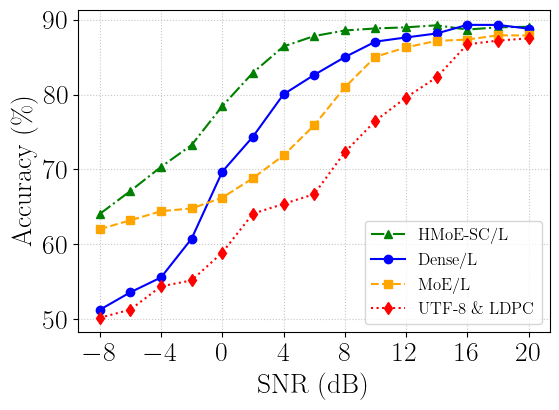

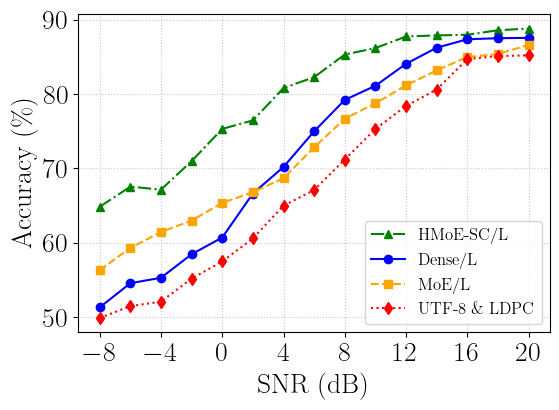

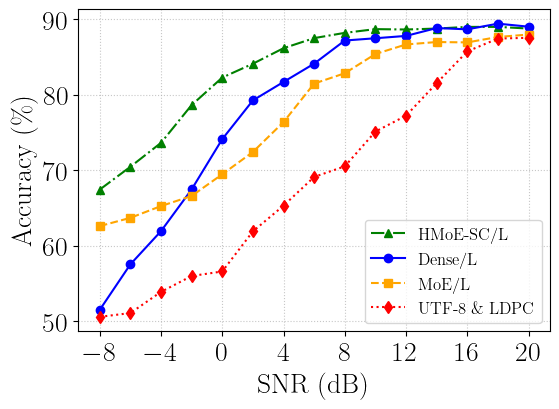

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random, json
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom 
from conventional_model import Conventional_Com

from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset

plt_paras = {'ytick.color' : 'black',
          'xtick.color' : 'black',
          'axes.labelcolor' : 'black',
          'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 16,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)

# load file with json
with open('acc_snr_full.json', 'r') as f:
    results = json.load(f)

snr_range = np.arange(-8, 22, 2)
fading_range = ['none', 'rayleigh', 'rician']

model_types = ['hmoe', 'dense', 'moe', 'conv']  
model_configs = {
    'dense': {'label': 'Dense/L', 'color': 'blue', 'marker': 'o', 'linestyle': '-'},
    'moe': {'label': 'MoE/L', 'color': 'orange', 'marker': 's', 'linestyle': '--'},
    'hmoe': {'label': 'HMoE-SC/L', 'color': 'green', 'marker': '^', 'linestyle': '-.'},
    'conv': {'label': 'UTF-8 \& LDPC', 'color': 'red', 'marker': 'd', 'linestyle': ':'},
}

for fading in fading_range:
    fig, axs = plt.subplots(figsize=(6, 4.5))

    # Accuracy plot
    for model in model_types:
        label = model_configs[model]['label']
        color = model_configs[model]['color']
        marker = model_configs[model]['marker']
        linestyle = model_configs[model]['linestyle']

        axs.plot(snr_range, results[model]['accuracy'][fading], label=label, marker=marker, color=color, linestyle=linestyle)

    # axs.set_title(f'Accuracy vs SNR ({fading} fading)')
    axs.set_xlabel(r'SNR (dB)')
    axs.set_ylabel(r'Accuracy (\%)')
    axs.legend(loc='best', fontsize=12)
    axs.grid(True)

    axs.set_xticks([-8, -4, 0, 4, 8, 12, 16, 20])  # Set specific x-ticks


    # # BLEU plot
    # for model in model_types:
    #     axs[1].plot(snr_range, results[model]['bleu'][fading], label=model)
    # axs[1].set_title(f'BLEU Score vs SNR ({fading} fading)')
    # axs[1].set_xlabel('SNR (dB)')
    # axs[1].set_ylabel('BLEU Score')
    # axs[1].legend()
    # axs[1].grid(True)

    plt.savefig(f'./figures/acc_{fading}_full.pdf', bbox_inches='tight')

    plt.tight_layout()
    plt.show()


In [ ]:
# fig 2: acc vs rician k factor, lines: models
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom 
from conventional_model import Conventional_Com

from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset

plt_paras = {'ytick.color' : 'black',
          'xtick.color' : 'black',
          'axes.labelcolor' : 'black',
          'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 13,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)


# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(1997) # 2006
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_dense = Transformer_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_encd_layer=6, transmit_dim=128, num_heads=8).to(device)

model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

model_moe = MoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

# model_conv = Conventional_Com(emded_dim=512).to(device) 


# model_moe.load_state_dict(torch.load("checkpoints/Dense_snr12_20250604_055257.pt"))

model_dense.load_state_dict(torch.load("checkpoints_new/Dense_sizeL_6_1_8_632_20250701_011126.pt", weights_only=True))
model_hetereo.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_6_12_8_632_20250702_084802.pt", weights_only=True)) 
model_moe.load_state_dict(torch.load("checkpoints_new/MoE_sizeL_20250709_015013.pt", weights_only=True)) 
# model_conv.load_state_dict(torch.load("checkpoints_new/...pt", weights_only=True))

# model_moe.eval()
model_dense.eval()
model_hetereo.eval()
model_moe.eval()
# model_conv.eval()

# Load data
dataset = load_dataset("glue", "qqp")
batch_size = 256


# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

full_test_dataset = dataset["validation"]
subset_indices = random.sample(range(len(full_test_dataset)), len(full_test_dataset) // 10)
small_test_dataset = full_test_dataset.select(subset_indices)
test_dataset = QQPPromptDataset(small_test_dataset)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
)

snr_range = np.array([-4.0])
k_rician_range = np.array([0.1, 0.5, 1, 3, 5, 10, 20, 30, 50]) # linear scale

# Results dicts
results = {
    'dense': {'accuracy': {k: [] for k in k_rician_range}, 'bleu': {k: [] for k in k_rician_range}},
    'moe': {'accuracy': {k: [] for k in k_rician_range}, 'bleu': {k: [] for k in k_rician_range}},
    'hmoe': {'accuracy': {k: [] for k in k_rician_range}, 'bleu': {k: [] for k in k_rician_range}},
    'conv': {'accuracy': {k: [] for k in k_rician_range}, 'bleu': {k: [] for k in k_rician_range}},
}


# Main evaluation loop
for snr in snr_range:
    for k in k_rician_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:
            for arch_name, model in [('dense', model_dense), ('hmoe', model_hetereo), ('moe', model_moe),]:
                for task in [0]:
                    with torch.no_grad():
                        if arch_name == 'dense':
                            outputs, input_ids, _, _, _ = model(texts, task, float(snr), 'rician', rician_k=k, modal=True)
                        elif arch_name == 'conv':
                            outputs = model(texts, float(snr), 'rician', rician_k=k)
                        elif arch_name == 'moe':
                            outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), 'rician', rician_k=k, modal=True) 
                        else:
                            outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), 'rician', rician_k=k, modal=False)

                        if task == 0:  # Classification
                            logits = outputs
                            preds = logits.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs.argmax(dim=-1).cpu().tolist()

                            tgt_ids_batch = input_ids[:, :len(pred_ids_batch[0])].cpu().tolist() 

                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=False)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=False)
                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total'] if metrics[arch_name]['total'] > 0 else 0
            bleu = np.mean(metrics[arch_name]['bleu_scores'])
            results[arch_name]['accuracy'][k].append(acc*100)
            results[arch_name]['bleu'][k].append(bleu)


model_types = ['hmoe', 'dense', 'moe',]  # NEW
model_configs = {
    'dense': {'label': 'Dense', 'color': 'blue', 'marker': 'o', 'linestyle': '-'},
    'moe': {'label': 'MoE', 'color': 'orange', 'marker': 's', 'linestyle': '--'},
    'hmoe': {'label': 'HMoE', 'color': 'green', 'marker': '^', 'linestyle': '-.'},
    'conv': {'label': 'Conventional', 'color': 'red', 'marker': 'd', 'linestyle': ':'},
}

fig, axs = plt.subplots()

# Accuracy plot
# sparse_ticks = [0, 0.5, 3, 10, 30, 50]

for model in model_types:
    label = model_configs[model]['label']
    color = model_configs[model]['color']
    marker = model_configs[model]['marker']
    linestyle = model_configs[model]['linestyle']
    
    axs.plot(k_rician_range, [results[model]['accuracy'][k] for k in k_rician_range], label=label, marker=marker, color=color, linestyle=linestyle)

# axs.set_title(f'Accuracy vs Rician K factor')
axs.set_xlabel(r'Rician $K$ factor')
axs.set_ylabel(r'Accuracy (\%)')
axs.legend(loc='best', fontsize=12)
axs.grid(True)
# axs[0].set_xticks(k_rician_range)
# axs[0].set_xticklabels(k_rician_range)  # or try sparse_ticks
axs.set_xscale('log')  

plt.savefig(f'./figures/k_rician.pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()

/home/necphy/Documents/duc_docs/SemCom/moe_semcom/moe_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


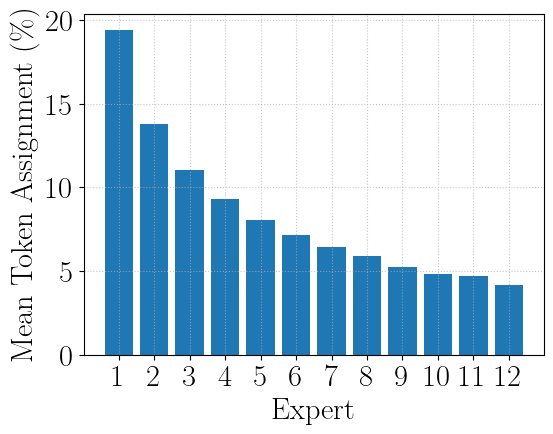

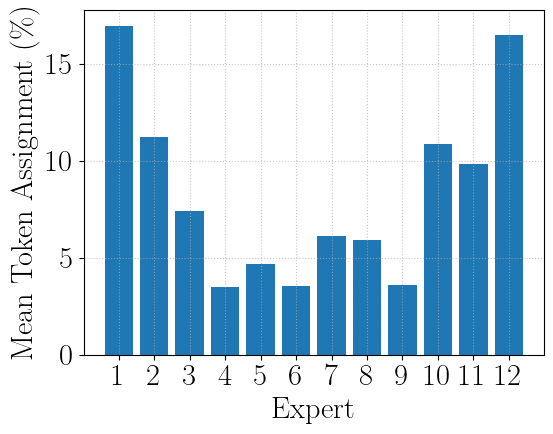

In [1]:
# fig 3: expert usage bars, accuracy, flops
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom 
# from conventional_model import Conventional_Com
from collections import defaultdict

from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset

plt_paras = {'ytick.color' : 'black',
          'xtick.color' : 'black',
          'axes.labelcolor' : 'black',
          'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 16,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)


# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(1997) # 2006
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
# model_dense = Transformer_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_encd_layer=6, transmit_dim=128, num_heads=8).to(device)

NUM_EXPERTS = 12

model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=NUM_EXPERTS, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

model_moe = MoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=NUM_EXPERTS, transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

# model_conv = Conventional_Com(emded_dim=512).to(device) 


# model_moe.load_state_dict(torch.load("checkpoints/Dense_snr12_20250604_055257.pt"))

# model_dense.load_state_dict(torch.load("checkpoints_new/Dense_sizeL_6_1_8_632_20250701_011126.pt", weights_only=True))
model_hetereo.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_6_12_8_632_20250702_084802.pt", weights_only=True)) 
model_moe.load_state_dict(torch.load("checkpoints_new/MoE_sizeL_20250709_015013.pt", weights_only=True)) 
# model_conv.load_state_dict(torch.load("checkpoints_new/Conv_Bert_20250708_224213.pt", weights_only=True))

# model_moe.eval()
# model_dense.eval()
model_hetereo.eval()
model_moe.eval()
# model_conv.eval()

# Load data
dataset = load_dataset("glue", "qqp")
batch_size = 256


# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

full_test_dataset = dataset["validation"]
subset_indices = random.sample(range(len(full_test_dataset)), len(full_test_dataset) // 10)
small_test_dataset = full_test_dataset.select(subset_indices)
test_dataset = QQPPromptDataset(small_test_dataset)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
)

snr_range = np.array([5.0])
fading_range = ['rician']
task_ids = [0]

for snr in snr_range:
    for fading in fading_range:
        for task in task_ids:
                
            for arch_name, model in [('hmoe', model_hetereo), ('moe', model_moe),]:
                
                expert_usage = [defaultdict(int) for _ in range(6)]

                for texts, labels in test_loader:
                    with torch.no_grad():
                        if arch_name == 'hmoe':
                            _, _, _, _, _, _, expert_masks = model(texts, task, snr=float(snr), fading=fading, modal=False)
                        else:
                            _, _, _, _, _, _, expert_masks = model(texts, task, snr=float(snr), fading=fading, modal=True)

                    for i, mask in enumerate(expert_masks):
                        topk_experts = torch.topk(mask, k=2, dim=-1).indices.cpu().numpy()

                        usage_dict = expert_usage[i]

                        for expert_ids in topk_experts:
                            for expert_id in expert_ids:
                                usage_dict[int(expert_id)] += 1

                # fig, axs = plt.subplots()

                # for i, usage_dict in enumerate(expert_usage):
                #     experts = sorted(usage_dict.keys())
                    
                #     counts = [usage_dict[e] for e in experts]
                #     normalized_counts = [count / sum(counts) * 100 for count in counts]


                #     axs.bar([f'EncL{i+1}_E{e}' for e in experts], normalized_counts, label=f'Layer {i+1}')


                # axs.set_ylabel(r'Token Assignment (\%)')
                # axs.set_xticklabels([])
                # axs.set_xlabel('Expert')
                # # axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
                # axs.legend(loc='upper right')
                # axs.grid(True)

                # plt.savefig(f'./figures/expert_usage_{arch_name}.pdf', bbox_inches='tight')

                # plt.tight_layout()
                # plt.show()

                all_experts = sorted(set().union(*[set(d.keys()) for d in expert_usage]))

                # Normalize each layer's counts to % and collect them
                layer_norms = []
                for usage_dict in expert_usage:
                    counts = np.array([usage_dict.get(e, 0) for e in all_experts], dtype=float)
                    if counts.sum() > 0:
                        norm = counts / counts.sum() * 100.0
                    else:
                        norm = np.zeros_like(counts)
                    layer_norms.append(norm)

                # Mean percentage per expert across layers
                mean_usage = np.mean(np.stack(layer_norms, axis=0), axis=0)  # shape: (N,)

                fig, ax = plt.subplots(figsize=(6, 4.8))

                ax.bar([f'{e+1}' for e in all_experts], mean_usage)
                ax.set_ylabel(r'Mean Token Assignment (\%)')
                ax.set_xlabel(r'Expert')
                ax.grid(True, axis='y')
                plt.tight_layout()

                plt.savefig(f'./figures/expert_usage_{arch_name}_mean.pdf', bbox_inches='tight')
                plt.show()



/home/necphy/Documents/duc_docs/SemCom/moe_semcom/moe_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


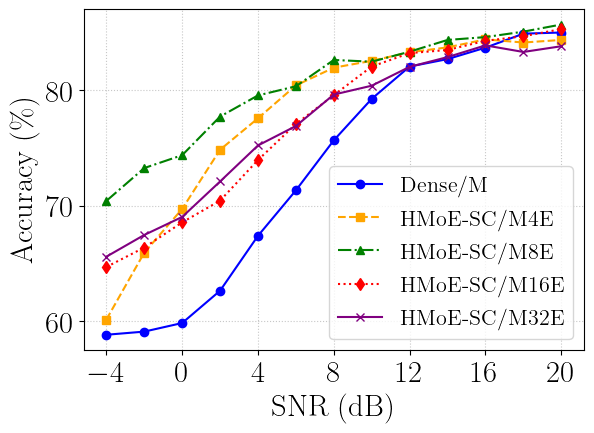

In [1]:
# fig 4: acc vs snr, lines: num of experts
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random, json
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom 
# from conventional_model import Conventional_Com
from collections import defaultdict

from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset

plt_paras = {'ytick.color' : 'black',
          'xtick.color' : 'black',
          'axes.labelcolor' : 'black',
          'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 16,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)


# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(1997) # 2006
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


num_experts = np.array([1, 4, 8, 16, 32])
models = []

for num_expert in num_experts:
    if num_expert == 1: # first model is dense
        model = Transformer_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_encd_layer=4, transmit_dim=128, num_heads=6).to(device)
        model.load_state_dict(torch.load(f"checkpoints_new/Dense_sizeM_4_1_6_412_20250701_034531.pt", weights_only=True))
    else: # other models are HMoE
        model = HetereoMoE_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_experts=num_expert, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4, num_heads=6).to(device) 
        model.load_state_dict(torch.load(f"checkpoints_new/HMoE_sizeM{num_expert}E.pt", weights_only=True))

    model.eval()
    models.append(model)


# Load data
dataset = load_dataset("glue", "qqp")
batch_size = 256

# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

full_test_dataset = dataset["validation"]
subset_indices = random.sample(range(len(full_test_dataset)), len(full_test_dataset) // 10)
small_test_dataset = full_test_dataset.select(subset_indices)
test_dataset = QQPPromptDataset(small_test_dataset)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
)

snr_range = np.arange(-4, 22, 2)
fading_range = ['rayleigh']

results = {
    'dense': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoe_4E': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoe_8E': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoe_16E': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoe_32E': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
}


for snr in snr_range:
    for fading in fading_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:
            for arch_name, model in zip(['dense'] + [f'hmoe_{num_expert}E' for num_expert in num_experts[1:]], models):

                for task in [0, 1]:
                    with torch.no_grad():
                        if arch_name == 'dense':
                            outputs, input_ids, _, _, _ = model(texts, task, snr=float(snr), fading=fading, modal=True)
                        else:
                            outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading, modal=False) 
                        
                        if task == 0:  # Classification
                            preds = outputs.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs.argmax(dim=-1).cpu().tolist()

                            tgt_ids_batch = input_ids[:, :len(pred_ids_batch[0])].cpu().tolist() 

                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=False)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=False)

                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total'] if metrics[arch_name]['total'] > 0 else 0
            bleu = np.mean(metrics[arch_name]['bleu_scores'])

            results[arch_name]['accuracy'][fading].append(acc*100)
            results[arch_name]['bleu'][fading].append(bleu)


model_types = ['dense'] + [f'hmoe_{num_expert}E' for num_expert in num_experts[1:]]

with open('acc_snr_experts.json', 'w') as f:
    json.dump(results, f)

model_configs = {
    'dense': {'label': 'Dense/M', 'color': 'blue', 'marker': 'o', 'linestyle': '-'},
    'hmoe_4E': {'label': 'HMoE-SC/M4E', 'color': 'orange', 'marker': 's', 'linestyle': '--'},
    'hmoe_8E': {'label': 'HMoE-SC/M8E', 'color': 'green', 'marker': '^', 'linestyle': '-.'},
    'hmoe_16E': {'label': 'HMoE-SC/M16E', 'color': 'red', 'marker': 'd', 'linestyle': ':'},
    'hmoe_32E': {'label': 'HMoE-SC/M32E', 'color': 'purple', 'marker': 'x', 'linestyle': '-'},
}

for fading in fading_range:
    fig, axs = plt.subplots()

    # Accuracy plot
    for model in model_types:
        axs.plot(snr_range, results[model]['accuracy'][fading], label=model_configs[model]['label'], marker=model_configs[model]['marker'], color=model_configs[model]['color'], linestyle=model_configs[model]['linestyle'])

    axs.set_xlabel(r'SNR (dB)')
    axs.set_ylabel(r'Accuracy (\%)')
    axs.legend(loc='best')
    # axs.grid(True)

    axs.set_xticks([-4, 0, 4, 8, 12, 16, 20])  
    plt.savefig(f'./figures/acc_snr_experts_{fading}.pdf', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

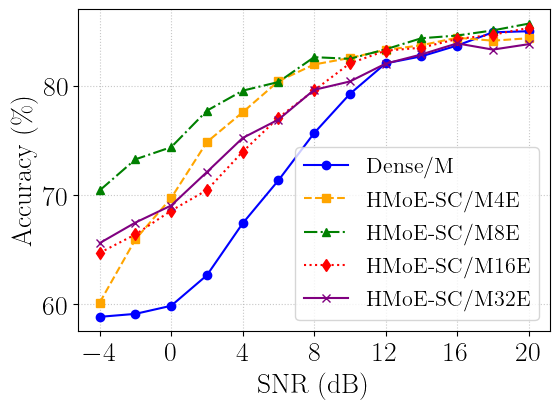

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random, json
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom 
# from conventional_model import Conventional_Com
from collections import defaultdict

from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset

plt_paras = {'ytick.color' : 'black',
          'xtick.color' : 'black',
          'axes.labelcolor' : 'black',
          'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 16,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)

for fading in fading_range:
    fig, axs = plt.subplots(figsize=(6, 4.5))

    # Accuracy plot
    for model in model_types:
        axs.plot(snr_range, results[model]['accuracy'][fading], label=model_configs[model]['label'], marker=model_configs[model]['marker'], color=model_configs[model]['color'], linestyle=model_configs[model]['linestyle'])

    axs.set_xlabel(r'SNR (dB)')
    axs.set_ylabel(r'Accuracy (\%)')
    axs.legend(loc='best')
    # axs.grid(True)

    axs.set_xticks([-4, 0, 4, 8, 12, 16, 20])  
    plt.savefig(f'./figures/acc_snr_experts_{fading}.pdf', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

In [ ]:
# table: flops vs acc
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom, Transformer_SemCom_XL 
from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset
from fvcore.nn import FlopCountAnalysis

plt_paras = {'ytick.color' : 'black',
          'xtick.color' : 'black',
          'axes.labelcolor' : 'black',
          'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 13,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)

# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(1997) # 2006
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dense_models = []

# dense model init
model_dense_sizeS = Transformer_SemCom(num_tasks=2, embed_dim=232, task_dim=8, num_encd_layer=2, transmit_dim=128, num_heads=4).to(device)
model_dense_sizeS.load_state_dict(torch.load("checkpoints_new/Dense_sizeS_2_1_4_232_20250630_234106.pt", weights_only=True))
model_dense_sizeS.eval()
dense_models.append(model_dense_sizeS)

model_dense_sizeM = Transformer_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_encd_layer=4, transmit_dim=128, num_heads=6).to(device)
model_dense_sizeM.load_state_dict(torch.load("checkpoints_new/Dense_sizeM_4_1_6_412_20250701_034531.pt", weights_only=True))
model_dense_sizeM.eval()
dense_models.append(model_dense_sizeM)

model_dense_sizeL = Transformer_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_encd_layer=6, transmit_dim=128, num_heads=8).to(device)
model_dense_sizeL.load_state_dict(torch.load("checkpoints_new/Dense_sizeL_6_1_8_632_20250701_011126.pt", weights_only=True))
model_dense_sizeL.eval()
dense_models.append(model_dense_sizeL)


model_dense_sizeXL = Transformer_SemCom_XL(num_tasks=2, embed_dim=1072, task_dim=8, num_encd_layer=8, transmit_dim=128, num_heads=12).to(device)
model_dense_sizeXL.load_state_dict(torch.load("checkpoints_new/Dense_sizeXL_8_1_12_1072_20250702_012300.pt", weights_only=True))
model_dense_sizeXL.eval()
dense_models.append(model_dense_sizeXL)

# hmoe model init
hmoe_models = []
model_hmoe_sizeS = HetereoMoE_SemCom(num_tasks=2, embed_dim=232, task_dim=8, num_experts=4, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=2, num_heads=4).to(device)
model_hmoe_sizeS.load_state_dict(torch.load("checkpoints_new/HMoE_sizeS_2_4_4_232_20250702_004214.pt", weights_only=True))
model_hmoe_sizeS.eval()
hmoe_models.append(model_hmoe_sizeS)

model_hmoe_sizeM = HetereoMoE_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_experts=8, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4, num_heads=6).to(device)
model_hmoe_sizeM.load_state_dict(torch.load("checkpoints_new/HMoE_sizeM8E.pt", weights_only=True))    
model_hmoe_sizeM.eval()
hmoe_models.append(model_hmoe_sizeM)

model_hmoe_sizeL = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8).to(device)
model_hmoe_sizeL.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_6_12_8_632_20250702_084802.pt", weights_only=True))
model_hmoe_sizeL.eval()
hmoe_models.append(model_hmoe_sizeL)

model_hmoe_sizeXL = HetereoMoE_SemCom(num_tasks=2, embed_dim=1072, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=8, num_heads=12).to(device)
model_hmoe_sizeXL.load_state_dict(torch.load("checkpoints_new/HMoE_sizeXL_8_12_12_1072_20250702_233648.pt", weights_only=True))
model_hmoe_sizeXL.eval()
hmoe_models.append(model_hmoe_sizeXL)

# Load data
dataset = load_dataset("glue", "qqp")
batch_size = 256

# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

full_test_dataset = dataset["validation"]
subset_indices = random.sample(range(len(full_test_dataset)), len(full_test_dataset) // 10)
small_test_dataset = full_test_dataset.select(subset_indices)
test_dataset = QQPPromptDataset(small_test_dataset)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
)

snr_range = np.array([2.0])
fading_range = ['rayleigh']  # 'none', 'rayleigh', 'rician' 

# model dict
models = dense_models + hmoe_models

# model_dict = {
#     'denseS': model_dense_sizeS,
#     'denseM': model_dense_sizeM,
#     'denseL': model_dense_sizeL,
#     'denseXL': model_dense_sizeXL,
#     'hmoeS': model_hmoe_sizeS,
#     'hmoeM': model_hmoe_sizeM,
#     'hmoeL': model_hmoe_sizeL,
#     'hmoeXL': model_hmoe_sizeXL,
# }

results = {
    'denseS': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoeS': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'denseM': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoeM': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'denseL': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoeL': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'denseXL': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoeXL': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
}

model_names = ['denseS', 'denseM', 'denseL', 'denseXL', 'hmoeS', 'hmoeM', 'hmoeL', 'hmoeXL',]

model_flops = {
    'denseS': [],
    'hmoeS': [],
    'denseM': [],
    'hmoeM': [],
    'denseL': [],
    'hmoeL': [],
    'denseXL': [],
    'hmoeXL': [],
}

for snr in snr_range:
    for fading in fading_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:

            for arch_name, model in zip(model_names, models):
                for task in [0, ]:
                    with torch.no_grad():
                        if 'dense' in arch_name:
                            outputs, input_ids, _, _, _ = model(texts, task, snr=float(snr), fading=fading, modal=True) # 0.7

                        else:
                            outputs, input_ids, _, _, _, _, expert_masks = model(texts, task, float(snr), fading, modal=False)  # 0.7

                        model_inputs = (texts, task, 2.0, 'rayleigh', 4.0,)
                        flops = FlopCountAnalysis(model, model_inputs)
                        model_flops[arch_name].append(flops.total())

                        if task == 0:  # Classification
                            preds = outputs.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs.argmax(dim=-1).cpu().tolist()

                            tgt_ids_batch = input_ids[:, :len(pred_ids_batch[0])].cpu().tolist() 

                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=False)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=False)

                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total'] if metrics[arch_name]['total'] > 0 else 0
            bleu = np.mean(metrics[arch_name]['bleu_scores'])

            results[arch_name]['accuracy'][fading].append(acc*100)
            results[arch_name]['bleu'][fading].append(bleu)


# compute mean flops per batch
for arch_name in model_flops.keys():
    model_flops[arch_name] = np.mean(model_flops[arch_name])

# print("Model FLOPs:")
# for arch_name, flops in model_flops.items():
#     print(f"{arch_name}: {flops:.2f} FLOPs per batch")

# print performance
for model in results.keys():
    print(f"Model: {model}")
    for fading in fading_range:
        print(f"  Fading: {fading}")
        print(f"    Accuracy: {results[model]['accuracy'][fading]}")
        print(f"    BLEU: {results[model]['bleu'][fading]}")
        print(f"    FLOPs: {model_flops[model]/1e9:.2f} GFLOPs per batch")


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom 
from conventional_model import Conventional_Com

from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset

plt_paras = {'ytick.color' : 'black',
          'xtick.color' : 'black',
          'axes.labelcolor' : 'black',
          'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 13,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)


# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(1997) # 2006
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

model_moe = MoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 




# model_moe.load_state_dict(torch.load("checkpoints/Dense_snr12_20250604_055257.pt"))

model_hetereo.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_6_12_8_632_20250702_084802.pt", weights_only=True)) 
model_moe.load_state_dict(torch.load("checkpoints_new/MoE_sizeL_20250709_015013.pt", weights_only=True)) 

# model_moe.eval()
model_hetereo.eval()
model_moe.eval()

# Load data
dataset = load_dataset("glue", "qqp")
batch_size = 256


# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

full_test_dataset = dataset["validation"]
subset_indices = random.sample(range(len(full_test_dataset)), len(full_test_dataset) // 40)
small_test_dataset = full_test_dataset.select(subset_indices)
test_dataset = QQPPromptDataset(small_test_dataset)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
)


snr_range = np.array([5.0, ])
fading_range = ['rician']

# Results dicts
results = {
    # 'dense': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'moe': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoe': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    # 'conv': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
}

model_flops = {
    'moe': [],
    'hmoe': [],
}

# Main evaluation loop
for snr in snr_range:
    for fading in fading_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:
            for arch_name, model in [('hmoe', model_hetereo), ('moe', model_moe),]:
                                    #  ('conv', model_conv)]: 

                for task in [0]:
                    with torch.no_grad():
                        if arch_name == 'dense':
                            outputs, input_ids, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=True)
                        elif arch_name == 'conv':
                            outputs = model(texts, float(snr), fading, rician_k=4.0, modal=True)
                        elif arch_name == 'moe':
                            outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=True)
                        else:
                            outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=False)

                        model_inputs = (texts, task, 5.0, 'rician', 4.0,)
                        flops = FlopCountAnalysis(model, model_inputs)
                        model_flops[arch_name].append(flops.total())

                        if task == 0:  # Classification
                            preds = outputs.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs.argmax(dim=-1).cpu().tolist()

                            tgt_ids_batch = input_ids[:, :len(pred_ids_batch[0])].cpu().tolist() 

                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=False)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=False)

                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total'] if metrics[arch_name]['total'] > 0 else 0
            bleu = np.mean(metrics[arch_name]['bleu_scores'])

            results[arch_name]['accuracy'][fading].append(acc*100)  
            results[arch_name]['bleu'][fading].append(bleu)

# Plotting: 3 figures, one per fading
# model_types = ['dense', 'moe', 'hetereoMoE']  # NEW
model_types = ['hmoe', 'dense', 'moe', ]  

# compute mean flops per batch
for arch_name in model_flops.keys():
    model_flops[arch_name] = np.mean(model_flops[arch_name])

# print("Model FLOPs:")
# for arch_name, flops in model_flops.items():
#     print(f"{arch_name}: {flops:.2f} FLOPs per batch")

# print performance
for model in results.keys():
    print(f"Model: {model}")
    for fading in fading_range:
        print(f"  Fading: {fading}")
        print(f"    Accuracy: {results[model]['accuracy'][fading]}")
        print(f"    FLOPs: {model_flops[model]/1e9:.2f} GFLOPs per batch")


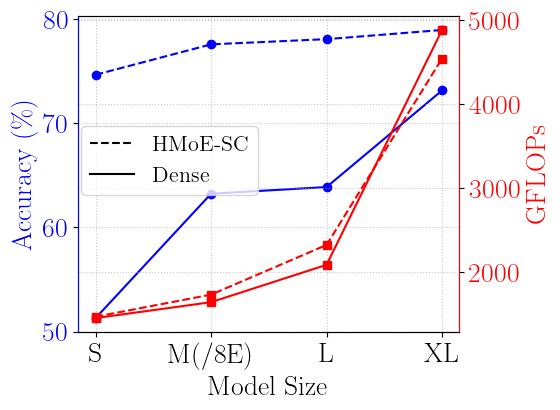

In [6]:
import matplotlib.pyplot as plt

plt_paras = {
          # 'ytick.color' : 'black',
          # 'xtick.color' : 'black',
          # 'axes.labelcolor' : 'black',
          # 'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 16,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)


# Data
categories = ['S', 'M(/8E)', 'L', 'XL']
dense_accuracy = [51.29, 63.24, 63.88, 73.16]
hmoe_accuracy = [74.67, 77.59, 78.09, 78.97]
dense_gflops = [1449.36, 1638.92, 2083.72, 4879.56]
hmoe_gflops = [1465.62, 1728.82, 2320.37, 4539.64]

x = range(len(categories))

fig, ax1 = plt.subplots(figsize=(6, 4.5))

# Plot accuracy on left axis with markers
ax1.set_xlabel('Model Size')
ax1.set_ylabel(r'Accuracy (\%)', color='blue')
line1, = ax1.plot(x, dense_accuracy, marker='o', linestyle='-', color='blue')
line2, = ax1.plot(x, hmoe_accuracy, marker='o', linestyle='--', color='blue')
# ax1.spines['left'].set_color('blue')
ax1.tick_params(axis='y', labelcolor='blue')
# ax1.spines['left'].set_color('blue')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)

ax2 = ax1.twinx()
ax2.set_ylabel('GFLOPs', color='red')
line3, = ax2.plot(x, dense_gflops, marker='s', linestyle='-', color='red')
line4, = ax2.plot(x, hmoe_gflops, marker='s', linestyle='--', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.spines['left'].set_color('blue')

ax2.spines['right'].set_color('red')



custom_lines = [
    plt.Line2D([0], [0], color='black', linestyle='--'),
    plt.Line2D([0], [0], color='black', linestyle='-'),
]
fig.legend(custom_lines, ['HMoE-SC', 'Dense'], loc='upper left', bbox_to_anchor=(0.15, 0.7))

plt.tight_layout()
plt.savefig(f'./figures/acc_gflops.pdf', bbox_inches='tight')
plt.show()


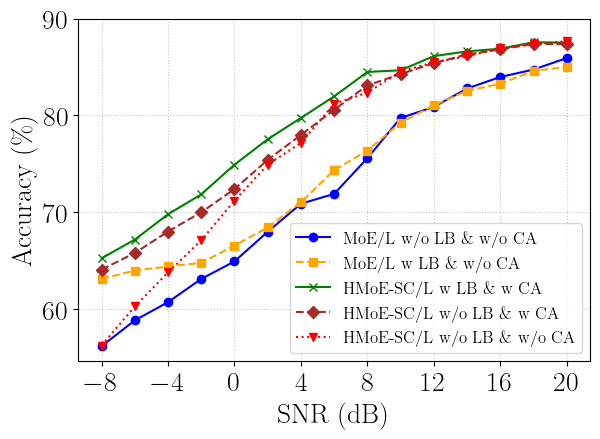

In [5]:
# fig1: acc vs snr, lines: models

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom 
# from conventional_model import Conventional_Com

from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset

plt_paras = {'ytick.color' : 'black',
          'xtick.color' : 'black',
          'axes.labelcolor' : 'black',
          'axes.edgecolor' : 'black',
          'text.usetex' : True,
          'font.family' : 'serif',
          'font.serif' : 'Computer Modern',
          'font.size': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
        #   'axes.labelsize': 16,
        #   'figure.labelsize': 16,
          'figure.autolayout': True,
          'legend.fontsize': 12,
          'legend.loc': 'best',
          'axes.grid': True,   
          'axes.grid.axis': 'both',    
          'axes.grid.which': 'both',
          'grid.alpha': 0.7,  # Adjust the opacity (0.0 to 1.0)

          'grid.linestyle': 'dotted',
        #   'lines.linewidth': 2,
        #   'lines.markersize': 7,  # Adjust the marker size as needed

        }

plt.rcParams.update(plt_paras)


# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(1997) # 2006
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
# model_dense = Transformer_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_encd_layer=6, transmit_dim=128, num_heads=8).to(device)

# model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

moe_woLB_woCA = MoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

moe_wLB_woCA = MoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

# hmoe_wLB_woCA = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8, snr_aware=False).to(device)

hmoe_wLB_wCA = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8, snr_aware=True).to(device)

hmoe_woLB_wCA = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8, snr_aware=True).to(device)

hmoe_woLB_woCA = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8, snr_aware=False).to(device)



moe_woLB_woCA.load_state_dict(torch.load("checkpoints_new/MoE_sizeL_20250709_015013.pt", weights_only=True))

moe_wLB_woCA.load_state_dict(torch.load("checkpoints_new/MoE_sizeL_wLB_20250723_080700.pt", weights_only=True))

# hmoe_wLB_woCA.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_woChannelAware.pt", weights_only=True))

hmoe_wLB_wCA.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_6_12_8_632_20250702_084802.pt", weights_only=True))

hmoe_woLB_wCA.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_woLB_20250723_183514.pt", weights_only=True))

hmoe_woLB_woCA.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_woCA_woLB_20250724_002859.pt", weights_only=True))



# model_moe.eval()
moe_wLB_woCA.eval()
moe_woLB_woCA.eval()
# hmoe_wLB_woCA.eval()
hmoe_wLB_wCA.eval()
hmoe_woLB_wCA.eval()
hmoe_woLB_woCA.eval()


# Load data
dataset = load_dataset("glue", "qqp")
batch_size = 256


# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

full_test_dataset = dataset["validation"]
subset_indices = random.sample(range(len(full_test_dataset)), len(full_test_dataset) // 10)
small_test_dataset = full_test_dataset.select(subset_indices)
test_dataset = QQPPromptDataset(small_test_dataset)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
)


snr_range = np.arange(-8, 22, 2)
fading_range = ['rayleigh']


# results = {
#     'moe_woLB_woCA': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
#     'moe_wLB_woCA': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
#     # 'hmoe_wLB_woCA': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
#     'hmoe_wLB_wCA': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
#     'hmoe_woLB_wCA': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
#     'hmoe_woLB_woCA': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
# }


# # Main evaluation loop
# for snr in snr_range:
#     for fading in fading_range:
#         metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

#         for texts, labels in test_loader:
#             # for arch_name, model in [('dense', model_dense), ('hmoe', model_hetereo), ('moe', model_moe),]:

#             for arch_name, model in [
#                 ('moe_woLB_woCA', moe_woLB_woCA),
#                 ('moe_wLB_woCA', moe_wLB_woCA),
#                 # ('hmoe_wLB_woCA', hmoe_wLB_woCA),
#                 ('hmoe_wLB_wCA', hmoe_wLB_wCA),
#                 ('hmoe_woLB_wCA', hmoe_woLB_wCA),
#                 ('hmoe_woLB_woCA', hmoe_woLB_woCA),
#             ]:

#                 for task in [0]:
#                     with torch.no_grad():
#                         # if arch_name == 'dense':
#                         #     outputs, input_ids, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=True)
#                         # elif arch_name == 'conv':
#                         #     outputs = model(texts, float(snr), fading, rician_k=4.0, modal=True)
#                         # elif arch_name == 'moe':
#                         #     outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=True)
#                         # else:
#                         #     outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=False)

#                         if arch_name.startswith('moe'):
#                             outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=True)
#                         else:
#                             outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading, rician_k=4.0, modal=False)

#                         if task == 0:  # Classification
#                             preds = outputs.argmax(dim=-1)
#                             metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
#                             metrics[arch_name]['total'] += labels.size(0)

#                         elif task == 1:  # Reconstruction
#                             pred_ids_batch = outputs.argmax(dim=-1).cpu().tolist()

#                             tgt_ids_batch = input_ids[:, :len(pred_ids_batch[0])].cpu().tolist() 

#                             pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=False)
#                             target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=False)

#                             for pred_text, target_text in zip(pred_texts, target_texts):
#                                 bleu = sentence_bleu(
#                                     [word_tokenize(target_text)],
#                                     word_tokenize(pred_text),
#                                     weights=(1, 0, 0, 0),
#                                     smoothing_function=SmoothingFunction().method4
#                                 )
#                                 metrics[arch_name]['bleu_scores'].append(bleu)

#         # Aggregate
#         for arch_name in results.keys():
#             acc = metrics[arch_name]['correct'] / metrics[arch_name]['total'] if metrics[arch_name]['total'] > 0 else 0
#             # bleu = np.mean(metrics[arch_name]['bleu_scores'])

#             results[arch_name]['accuracy'][fading].append(acc*100)  
#             # results[arch_name]['bleu'][fading].append(bleu)

# results['conv']['accuracy']['none'] = [
#     48.52, 48.93, 49.66, 50.89, 52.89, 55.94, 60.09,
#     65.00, 69.91, 74.06, 77.11, 79.11, 80.34, 81.07, 81.48
# ]
# results['conv']['accuracy']['rayleigh'] = [
#     45.46, 45.82, 46.46, 47.55, 49.32, 52.01, 55.67,
#     60.00, 64.33, 67.99, 70.68, 72.45, 73.54, 74.18, 74.54
# ]

# results['conv']['accuracy']['rician'] = [
#     47.49, 47.88, 48.56, 49.72, 51.61, 54.47, 58.38,
#     63.00, 67.62, 71.53, 74.39, 76.28, 77.44, 78.12, 78.51
# ]


# Plotting: 3 figures, one per fading
# model_types = ['dense', 'moe', 'hetereoMoE']  # NEW

import json
with open('results_ablation.json', 'r') as f:
    results = json.load(f)
    

model_types = ['moe_woLB_woCA',
                'moe_wLB_woCA',
                # 'hmoe_wLB_woCA',
                'hmoe_wLB_wCA',
                'hmoe_woLB_wCA',
                'hmoe_woLB_woCA'
                ]

model_configs = {
    'moe_woLB_woCA': {'label': 'MoE/L w/o LB \& w/o CA', 'color': 'blue', 'marker': 'o', 'linestyle': '-'},
    'moe_wLB_woCA': {'label': 'MoE/L w LB \& w/o CA', 'color': 'orange', 'marker': 's', 'linestyle': '--'},
    # 'hmoe_wLB_woCA': {'label': 'HMoE w LB \& w/o CA', 'color': 'green', 'marker': '^', 'linestyle': '-.'},
    'hmoe_wLB_wCA': {'label': 'HMoE-SC/L w LB \& w CA', 'color': 'green', 'marker': 'x', 'linestyle': '-'},
    'hmoe_woLB_wCA': {'label': 'HMoE-SC/L w/o LB \& w CA', 'color': 'brown', 'marker': 'D', 'linestyle': '--'},
    'hmoe_woLB_woCA': {'label': 'HMoE-SC/L w/o LB \& w/o CA', 'color': 'red', 'marker': 'v', 'linestyle': ':'},
}

for fading in fading_range:
    fig, axs = plt.subplots()

    # Accuracy plot
    for model in model_types:
        label = model_configs[model]['label']
        color = model_configs[model]['color']
        marker = model_configs[model]['marker']
        linestyle = model_configs[model]['linestyle']

        axs.plot(snr_range, results[model]['accuracy'][fading], label=label, marker=marker, color=color, linestyle=linestyle)

    # axs.set_title(f'Accuracy vs SNR ({fading} fading)')
    axs.set_xlabel(r'SNR (dB)')
    axs.set_ylabel(r'Accuracy (\%)')
    axs.set_ylim(ymax=90)
    axs.legend(loc='best')
    axs.grid(True)

    axs.set_xticks([-8, -4, 0, 4, 8, 12, 16, 20])  # Set specific x-ticks


    # # BLEU plot
    # for model in model_types:
    #     axs[1].plot(snr_range, results[model]['bleu'][fading], label=model)
    # axs[1].set_title(f'BLEU Score vs SNR ({fading} fading)')
    # axs[1].set_xlabel('SNR (dB)')
    # axs[1].set_ylabel('BLEU Score')
    # axs[1].legend()
    # axs[1].grid(True)

    plt.savefig(f'./figures/acc_{fading}_ablation.pdf', bbox_inches='tight')

    plt.tight_layout()
    plt.show()